In [1]:
#NOTE: use python env acmil in ACMIL folder
import sys
import os
import numpy as np
import openslide
import matplotlib.pyplot as plt

import matplotlib
matplotlib.use('Agg')
import pandas as pd
import warnings
import torch
import torch.nn as nn

from sklearn.model_selection import KFold, train_test_split
from torch.utils.data import DataLoader, Subset, ConcatDataset
import torch.optim as optim
from pathlib import Path
import PIL
from skimage import filters
import random

    
sys.path.insert(0, '../Utils/')
from Utils import create_dir_if_not_exists
from Utils import generate_deepzoom_tiles, extract_tile_start_end_coords, get_map_startend
from Utils import get_downsample_factor
from Utils import minmax_normalize, set_seed
from Utils import log_message
from Eval import compute_performance, plot_LOSS, compute_performance_each_label, get_attention_and_tileinfo
from train_utils import pull_tiles
from train_utils import ModelReadyData_diffdim, convert_to_dict, prediction_sepatt, BCE_Weighted_Reg, BCE_Weighted_Reg_focal, compute_loss_for_all_labels_sepatt
from Model import Mutation_MIL_MT_sepAtt #, Mutation_MIL_MT
warnings.filterwarnings("ignore")
%matplotlib inline


#FOR ACMIL
current_dir = os.getcwd()
grandparent_subfolder = os.path.join(current_dir, '..', '..', 'other_model_code','ACMIL-main')
grandparent_subfolder = os.path.normpath(grandparent_subfolder)
sys.path.insert(0, grandparent_subfolder)
from architecture.transformer import ACMIL_GA
from utils.utils import save_model, Struct, set_seed
import yaml
import sys
import os
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
import yaml
from pprint import pprint

import argparse
import torch
from torch import nn
from torch.utils.data import DataLoader

from utils.utils import save_model, Struct, set_seed
from datasets.datasets import build_HDF5_feat_dataset
from architecture.transformer import ACMIL_GA #ACMIL_GA
from architecture.transformer import ACMIL_MHA
import torch.nn.functional as F

from utils.utils import MetricLogger, SmoothedValue, adjust_learning_rate
from timm.utils import accuracy
import torchmetrics
import wandb

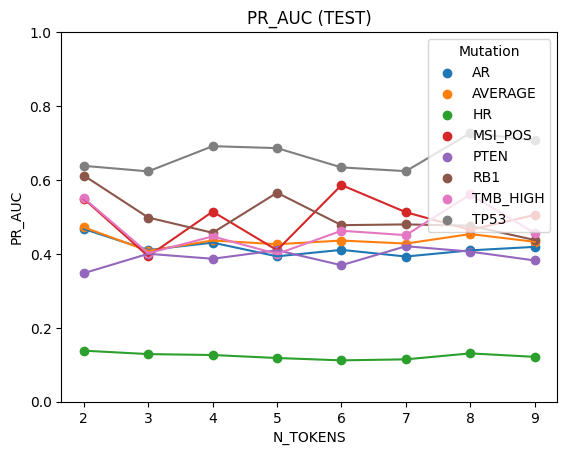

In [107]:
TMA_TFT = 0.0
cohort = "TEST"
s_outcome = "PR_AUC" #PR_AUC
perf_dir = "/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out02062025/retccl/" 
perf_dir2 = perf_dir + "MAXSSALLTUMORTILES_TrainOL100_TestOL0_TRAINTEST_TFT0.9_TMA_TFT" + str(TMA_TFT) + "/split_fold0/DL_emb_only/MT/perf/"

perf_list = []
for i in range(2,10):
    perf_df = pd.read_csv(perf_dir2+ 'n_token' + str(i) + '_' + cohort + '_perf.csv')
    perf_df['N_TOKENS'] = i
    perf_list.append(perf_df)
all_perf_df = pd.concat(perf_list)
all_perf_df.rename(columns = {'AUC': 'ROCAUC'}, inplace = True)
all_perf_df.loc[all_perf_df['OUTCOME'] == 'MMR (MSH2, MSH6, PMS2, MLH1, MSH3, MLH3, EPCAM)2','OUTCOME'] = 'HR'
all_perf_df.loc[all_perf_df['OUTCOME'] == 'TMB_HIGHorINTERMEDITATE','OUTCOME'] = 'TMB_HIGH'


# Calculate the average of ROCAUC for each OUTCOME
average_metrics = all_perf_df.groupby('N_TOKENS')[['ROCAUC', 'ACC', 'F1', 'F2', 'F3', 'Recall', 'Precision',
       'Specificity', 'PR_AUC']].mean().reset_index()
average_metrics['OUTCOME'] = 'AVERAGE'
average_metrics['Unnamed: 0'] = pd.NA
average_metrics = average_metrics[all_perf_df.columns]
all_perf_df = pd.concat([all_perf_df, average_metrics], ignore_index=True)
all_perf_df.to_csv(perf_dir2  + "ALL_" + cohort + "_perf.csv",index = True)

# Create scatter plot
all_perf_df.plot.scatter(x='N_TOKENS', y=s_outcome, title='Sample Scatter Plot')


tab10 = plt.get_cmap('tab10')
# Define custom colors for each group
colors = {
    'AR': tab10(0),       # First color in tab10
    'AVERAGE': tab10(1),  # Second color in tab10
    'HR': tab10(2),       # Third color in tab10
    'MSI_POS': tab10(3),  # Fourth color in tab10
    'PTEN': tab10(4),     # Fifth color in tab10
    'RB1': tab10(5),      # Sixth color in tab10
    'TMB_HIGH': tab10(6), # Seventh color in tab10
    'TP53': tab10(7)      # Eighth color in tab10
}

# Create scatter plot with grouping
groups = all_perf_df.groupby('OUTCOME')
for name, group in groups:
    plt.scatter(group['N_TOKENS'], group[s_outcome], label=name, color=colors.get(name, 'black'))
    plt.plot(group['N_TOKENS'], group[s_outcome], color=colors.get(name, 'black'))

# Add title and labels
plt.title(s_outcome + ' (' + cohort +  ')')
plt.xlabel('N_TOKENS')
plt.ylabel(s_outcome)
plt.legend(title='Mutation')
plt.ylim(0, 1)
plt.savefig(perf_dir2 + s_outcome + '_' + cohort+ '_scatter_plot.png')
# Show plot
plt.show()

In [99]:
set(all_perf_df['OUTCOME'])

{'AR', 'AVERAGE', 'HR', 'MSI_POS', 'PTEN', 'RB1', 'TMB_HIGH', 'TP53'}